# Sentiment Analysis for Social Media Comments

This notebook performs sentiment analysis on comments scraped from TikTok and Instagram.
It includes:
- Data loading and preprocessing
- Sentiment analysis using TextBlob
- Word cloud generation
- Sentiment distribution visualization

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import re
import os
import json
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Set style for matplotlib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

## 1. Data Loading and Preprocessing

In [6]:
def load_data():
    """Load data from both TikTok and Instagram scrapers"""
    data_frames = []
    
    # Load TikTok data
    tiktok_path = '../data/tiktok/all_comments.csv'
    if os.path.exists(tiktok_path):
        tiktok_df = pd.read_csv(tiktok_path)
        tiktok_df['platform'] = 'TikTok'
        tiktok_df['text'] = tiktok_df.get('comment', '')
        data_frames.append(tiktok_df)
        print(f"Loaded {len(tiktok_df)} TikTok comments")
    else:
        print("TikTok data not found")
    
    # Load Instagram data
    instagram_path = '../data/instagram/all_instagram_comments.csv'
    if os.path.exists(instagram_path):
        instagram_df = pd.read_csv(instagram_path)
        instagram_df['platform'] = 'Instagram'
        instagram_df['text'] = instagram_df.get('comment', '')
        data_frames.append(instagram_df)
        print(f"Loaded {len(instagram_df)} Instagram comments")
    else:
        print("Instagram data not found")
    
    if data_frames:
        combined_df = pd.concat(data_frames, ignore_index=True)
        return combined_df
    else:
        print("No data found. Please run the scrapers first.")
        return pd.DataFrame()

# Load the data
df = load_data()
print(f"\nTotal comments loaded: {len(df)}")
if not df.empty:
    print(f"Platforms: {df['platform'].value_counts().to_dict()}")
    print(f"\nData shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")

Loaded 30 TikTok comments
Loaded 8 Instagram comments

Total comments loaded: 38
Platforms: {'TikTok': 30, 'Instagram': 8}

Data shape: (38, 15)

Columns: ['comment_id', 'username', 'nickname', 'comment', 'create_time', 'avatar', 'total_reply', 'replies', 'aweme_id', 'platform', 'text', 'created_at', 'is_reply', 'parent_comment_id', 'post_id']


In [7]:
def clean_text(text):
    """Clean and preprocess text for analysis"""
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to string
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions and hashtags for sentiment analysis (but keep the text)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Clean the text data
if not df.empty:
    df['cleaned_text'] = df['text'].apply(clean_text)
    
    # Remove empty comments
    df = df[df['cleaned_text'].str.len() > 0]
    
    print(f"After cleaning: {len(df)} comments")
    print(f"Sample cleaned comments:")
    print(df['cleaned_text'].head().tolist())

After cleaning: 38 comments
Sample cleaned comments:
['imi rambut bulan bulan awal 2023 kalp gasalah', 'anu... 💍', 'fyp😳😳😊😊anime', 'Kak', 'apa ini?🥺']


## 2. Sentiment Analysis

In [8]:
def analyze_sentiment(text):
    """Analyze sentiment using TextBlob"""
    if not text or text.strip() == '':
        return 0, 0, 'neutral'
    
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    
    # Classify sentiment
    if polarity > 0.1:
        sentiment = 'positive'
    elif polarity < -0.1:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return polarity, subjectivity, sentiment

# Perform sentiment analysis
if not df.empty:
    print("Performing sentiment analysis...")
    
    sentiment_results = df['cleaned_text'].apply(analyze_sentiment)
    df[['polarity', 'subjectivity', 'sentiment']] = pd.DataFrame(sentiment_results.tolist(), index=df.index)
    
    print("Sentiment analysis completed!")
    print(f"\nSentiment distribution:")
    print(df['sentiment'].value_counts())
    
    print(f"\nAverage polarity: {df['polarity'].mean():.3f}")
    print(f"Average subjectivity: {df['subjectivity'].mean():.3f}")

Performing sentiment analysis...
Sentiment analysis completed!

Sentiment distribution:
sentiment
neutral     36
positive     2
Name: count, dtype: int64

Average polarity: 0.018
Average subjectivity: 0.047


## 3. Word Cloud Generation

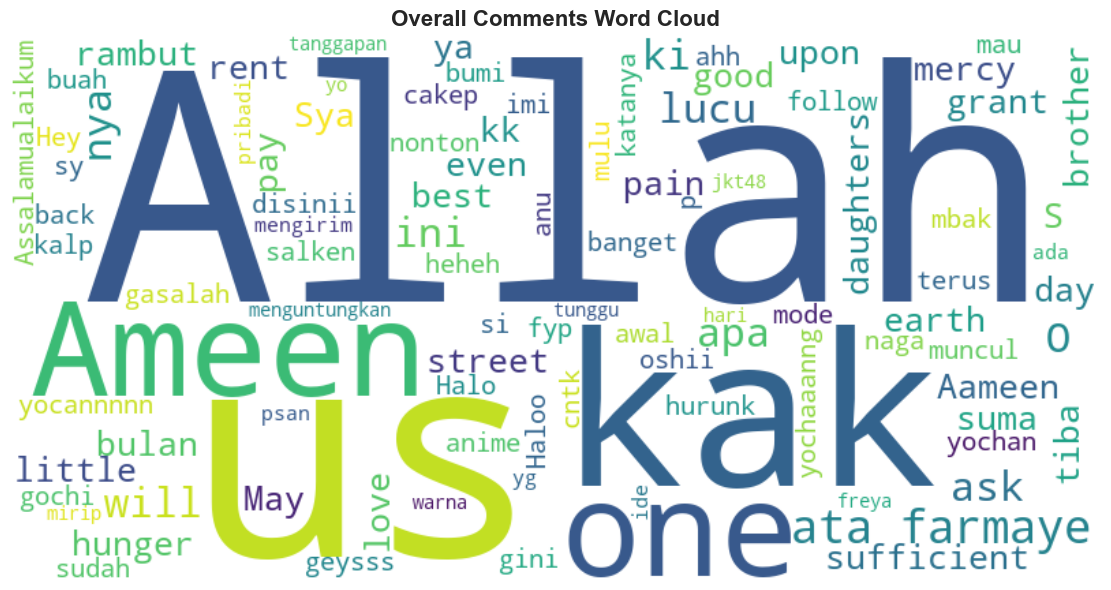

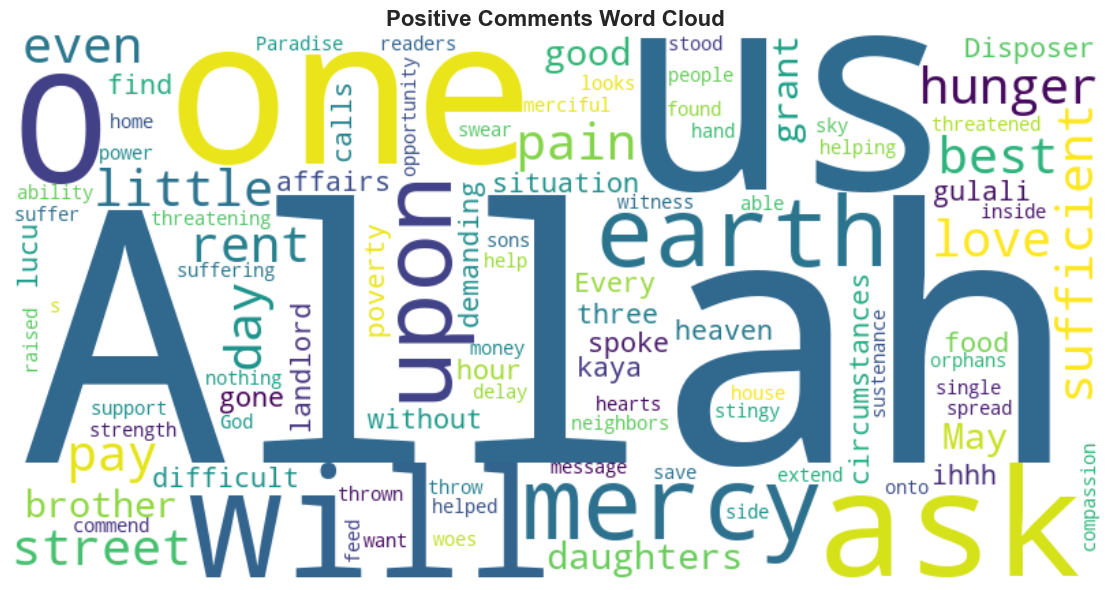

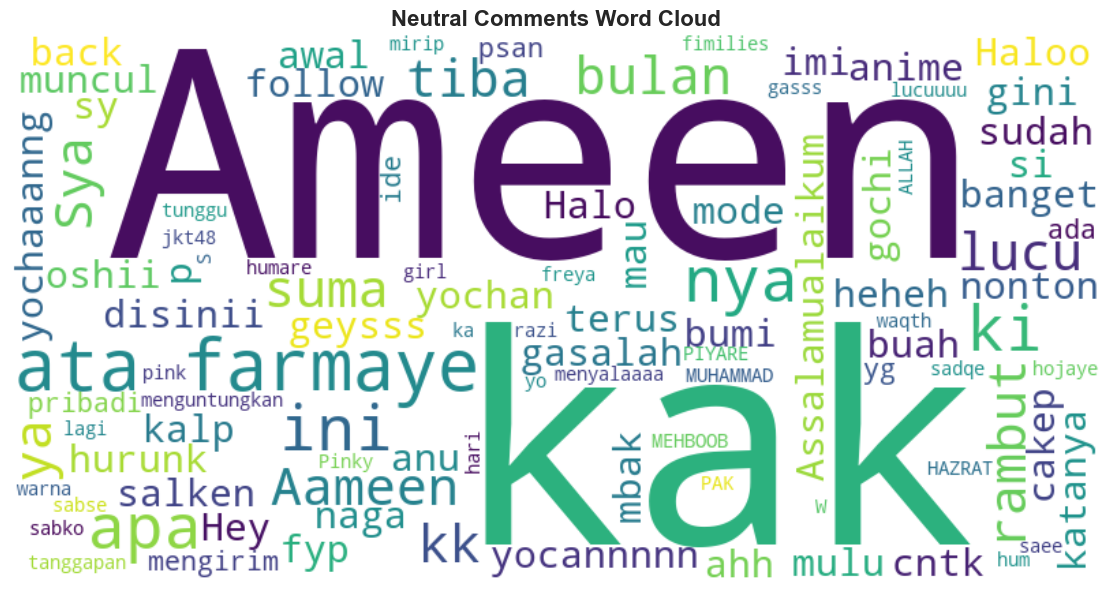

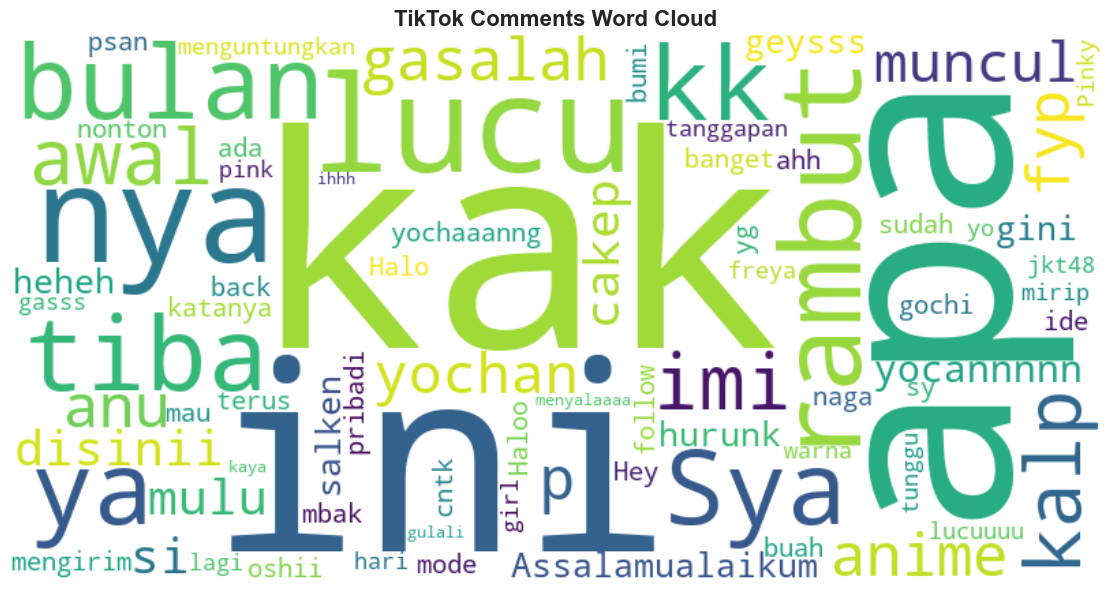

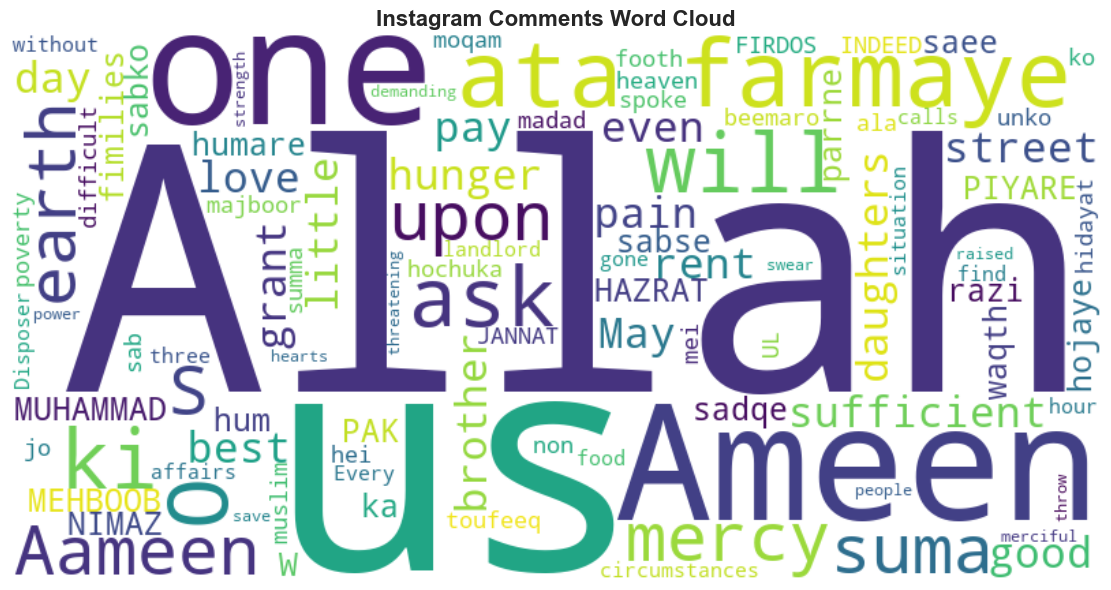

In [9]:
def create_wordcloud(text_data, title="Word Cloud", max_words=100):
    """Create and display word cloud"""
    if not text_data:
        print("No text data available for word cloud")
        return
    
    # Combine all text
    all_text = ' '.join(text_data)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=max_words,
        colormap='viridis'
    ).generate(all_text)
    
    # Display
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

if not df.empty:
    # Overall word cloud
    create_wordcloud(df['cleaned_text'].tolist(), "Overall Comments Word Cloud")
    
    # Word clouds by sentiment
    for sentiment in ['positive', 'negative', 'neutral']:
        sentiment_texts = df[df['sentiment'] == sentiment]['cleaned_text'].tolist()
        if sentiment_texts:
            create_wordcloud(sentiment_texts, f"{sentiment.title()} Comments Word Cloud")
    
    # Word clouds by platform
    for platform in df['platform'].unique():
        platform_texts = df[df['platform'] == platform]['cleaned_text'].tolist()
        if platform_texts:
            create_wordcloud(platform_texts, f"{platform} Comments Word Cloud")

## 4. Sentiment Distribution Visualization

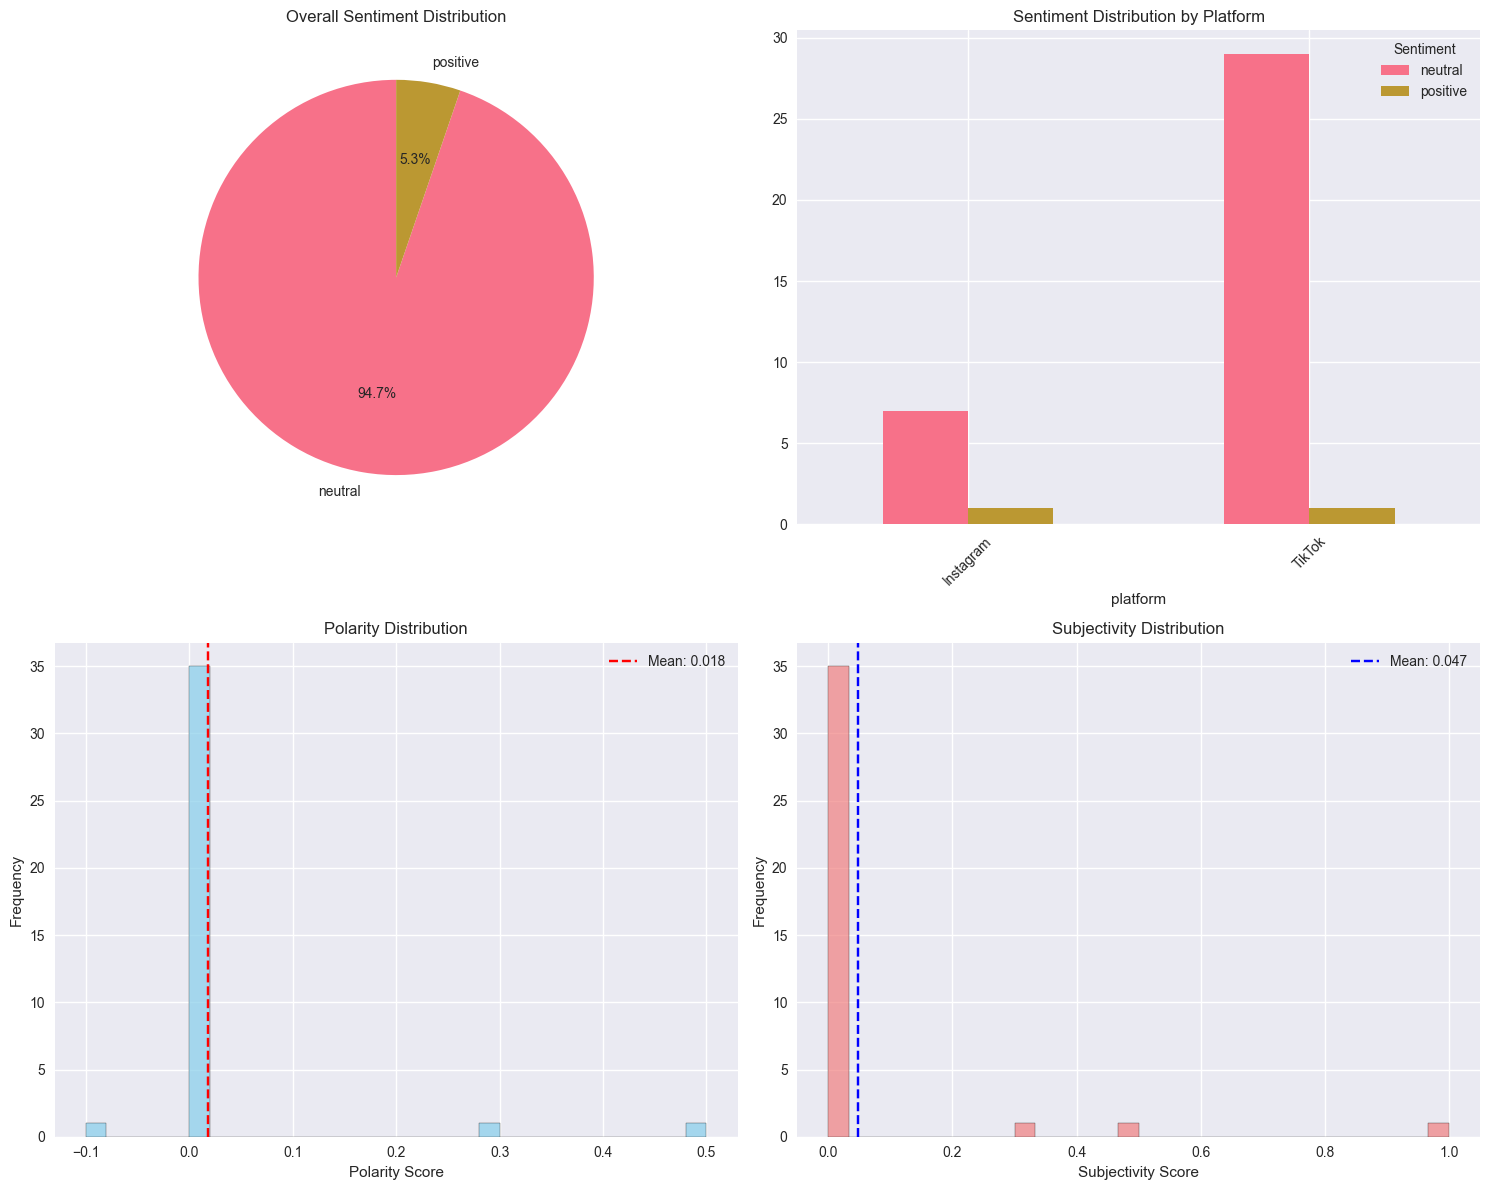

In [10]:
if not df.empty:
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Overall sentiment distribution
    sentiment_counts = df['sentiment'].value_counts()
    axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Overall Sentiment Distribution')
    
    # 2. Sentiment by platform
    sentiment_platform = pd.crosstab(df['platform'], df['sentiment'])
    sentiment_platform.plot(kind='bar', ax=axes[0, 1], rot=45)
    axes[0, 1].set_title('Sentiment Distribution by Platform')
    axes[0, 1].legend(title='Sentiment')
    
    # 3. Polarity distribution
    axes[1, 0].hist(df['polarity'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].axvline(df['polarity'].mean(), color='red', linestyle='--', label=f'Mean: {df["polarity"].mean():.3f}')
    axes[1, 0].set_title('Polarity Distribution')
    axes[1, 0].set_xlabel('Polarity Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    
    # 4. Subjectivity distribution
    axes[1, 1].hist(df['subjectivity'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, 1].axvline(df['subjectivity'].mean(), color='blue', linestyle='--', label=f'Mean: {df["subjectivity"].mean():.3f}')
    axes[1, 1].set_title('Subjectivity Distribution')
    axes[1, 1].set_xlabel('Subjectivity Score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

## 5. Interactive Visualizations with Plotly

In [11]:
if not df.empty:
    # Interactive sentiment distribution by platform
    fig = px.sunburst(
        df, 
        path=['platform', 'sentiment'], 
        title='Sentiment Distribution by Platform (Interactive)'
    )
    fig.show()
    
    # Scatter plot: Polarity vs Subjectivity
    fig = px.scatter(
        df, 
        x='polarity', 
        y='subjectivity', 
        color='sentiment',
        hover_data=['platform', 'username'],
        title='Polarity vs Subjectivity by Sentiment'
    )
    fig.show()
    
    # Box plot of polarity by platform
    fig = px.box(
        df, 
        x='platform', 
        y='polarity', 
        color='platform',
        title='Polarity Distribution by Platform'
    )
    fig.show()

## 6. Detailed Analysis and Statistics

In [12]:
if not df.empty:
    print("=== SENTIMENT ANALYSIS SUMMARY ===")
    print(f"\nTotal comments analyzed: {len(df)}")
    
    # Platform breakdown
    print("\n--- Platform Breakdown ---")
    platform_stats = df.groupby('platform').agg({
        'sentiment': lambda x: x.value_counts().to_dict(),
        'polarity': ['mean', 'std'],
        'subjectivity': ['mean', 'std']
    })
    print(platform_stats)
    
    # Sentiment statistics
    print("\n--- Sentiment Statistics ---")
    sentiment_stats = df.groupby('sentiment').agg({
        'polarity': ['count', 'mean', 'std', 'min', 'max'],
        'subjectivity': ['mean', 'std']
    })
    print(sentiment_stats)
    
    # Most common words by sentiment
    print("\n--- Most Common Words by Sentiment ---")
    for sentiment in ['positive', 'negative', 'neutral']:
        sentiment_text = ' '.join(df[df['sentiment'] == sentiment]['cleaned_text'])
        words = re.findall(r'\b\w+\b', sentiment_text.lower())
        common_words = Counter(words).most_common(10)
        print(f"\n{sentiment.upper()} - Top 10 words:")
        for word, count in common_words:
            print(f"  {word}: {count}")

=== SENTIMENT ANALYSIS SUMMARY ===

Total comments analyzed: 38

--- Platform Breakdown ---
                                sentiment  polarity           subjectivity  \
                                 <lambda>      mean       std         mean   
platform                                                                     
Instagram   {'neutral': 7, 'positive': 1}  0.036071  0.102025     0.061786   
TikTok     {'neutral': 29, 'positive': 1}  0.013333  0.093710     0.043333   

                     
                std  
platform             
Instagram  0.174756  
TikTok     0.188795  

--- Sentiment Statistics ---
          polarity                                    subjectivity          
             count      mean       std       min  max         mean       std
sentiment                                                                   
neutral         36 -0.002778  0.016667 -0.100000  0.0     0.008333  0.050000
positive         2  0.394286  0.149503  0.288571  0.5     0.747143  0

## 7. Export Results

In [ ]:
if not df.empty:
    # Save analyzed data
    output_path = '../data/sentiment_analysis_results.csv'
    df.to_csv(output_path, index=False)
    print(f"Results saved to: {output_path}")
    
    # Create summary statistics file
    summary_stats = {
        'total_comments': len(df),
        'platform_distribution': df['platform'].value_counts().to_dict(),
        'sentiment_distribution': df['sentiment'].value_counts().to_dict(),
        'average_polarity': df['polarity'].mean(),
        'average_subjectivity': df['subjectivity'].mean(),
        'polarity_by_platform': df.groupby('platform')['polarity'].mean().to_dict(),
        'sentiment_by_platform': df.groupby(['platform', 'sentiment']).size().to_dict()
    }
    
    summary_path = '../data/sentiment_summary.json'
    with open(summary_path, 'w') as f:
        json.dump(summary_stats, f, indent=2)
    
    print(f"Summary statistics saved to: {summary_path}")
    print("\nAnalysis complete!")